In [1]:
import sys
import os
sys.path.append(os.path.join(str(os.path.abspath('')), "..", "..", ".."))

from src.utils.losses import DiceLoss, DiceBCELoss
# from src.utils.dice_coef import DiceCoef
from src.utils.set_seed import seed_torch
from src.utils.transforms import get_transform

from sklearn.model_selection import GroupKFold
import torch
from torch import nn
import torchvision
import cv2
import os
import numpy as np
import pandas as pd
from torchvision import transforms
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
from torch.optim import Adam, SGD
from torch.optim.lr_scheduler import CosineAnnealingLR, ReduceLROnPlateau, CosineAnnealingWarmRestarts
from scipy.ndimage.interpolation import zoom
import albumentations as A
from torch.nn import functional as F
from albumentations.pytorch import ToTensorV2

import matplotlib.pyplot as plt
import sys
import time
import random

import segmentation_models_pytorch as smp
from segmentation_models_pytorch import Unet, FPN, UnetPlusPlus

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
class CFG:
    data = 512 #256
#     debug=False
#     apex=False
#     print_freq=100
    num_workers=4
    img_size=512 # appropriate input size for encoder 
#     epoch=60 # Change epochs
    criterion= 'DiceBCELoss' #'DiceBCELoss' # ['DiceLoss', 'Hausdorff', 'Lovasz']
#     lr=1e-3
#     min_lr=1e-5
    batch_size=1
#     weight_decay=1e-5
    seed=2021
#     n_fold=5
#     trn_fold=[0, 1, 2, 3, 4]
#     train=True
#     inference=False
#     optimizer = 'Adam'
#     T_0=10
    # N=5 
    # M=9
#     T_max=10
#     factor=0.1
#     patience=4
#     eps=1e-8
#     smoothing=1
#     train_transform_type = 'strong'
    valid_transform_type = 'val'

In [3]:
PREDICTION_THRESHOLD = 0.4
dir_df = pd.read_csv("dir_df.csv")
seed_torch(seed=CFG.seed)
valid_transform = get_transform(img_size=CFG.img_size, transform_type=CFG.valid_transform_type)
RESIZED_DATA_DIR = '../../../../../hdd/storage/kidney_segmentation/working_kaggle/resized_data_kaggle_lafoss/'

In [4]:
class HuBMAPDataset(Dataset):
    def __init__(self,df, train='train', transform=True):
        ids = df.id.values
        #kf = KFold(n_splits=nfolds,random_state=SEED,shuffle=True)
        #ids = set(ids[list(kf.split(ids))[fold][0 if train else 1]])
        if CFG.data==1024:
            self.fnames = [fname for fname in os.listdir(RESIZED_DATA_DIR + '1024*1024/train/') if fname.split('_')[0] in ids]
        elif CFG.data==512:
            self.fnames = [fname for fname in os.listdir(RESIZED_DATA_DIR + '512*512/train/') if fname.split('_')[0] in ids]
        elif CFG.data==256:
            self.fnames = [fname for fname in os.listdir(RESIZED_DATA_DIR + '256*256/train/') if fname.split('_')[0] in ids]
        self.train = train
        self.transform = transform
#         print(self.fnames)
        
    def __len__(self):
        return len(self.fnames)
    
    def __getitem__(self, idx):
        fname = self.fnames[idx]
        if CFG.data==1024:
            img = cv2.cvtColor(cv2.imread(os.path.join(RESIZED_DATA_DIR + '1024*1024/train/',fname)), cv2.COLOR_BGR2RGB)
            mask = cv2.imread(os.path.join(RESIZED_DATA_DIR + '1024*1024/masks',fname),cv2.IMREAD_GRAYSCALE)
        elif CFG.data==512:
            img = cv2.cvtColor(cv2.imread(os.path.join(RESIZED_DATA_DIR + '512*512/train/',fname)), cv2.COLOR_BGR2RGB)
            mask = cv2.imread(os.path.join(RESIZED_DATA_DIR + '512*512/masks',fname),cv2.IMREAD_GRAYSCALE)
        elif CFG.data==256:
            img = cv2.cvtColor(cv2.imread(os.path.join(RESIZED_DATA_DIR + '256*256/train/',fname)), cv2.COLOR_BGR2RGB)
            mask = cv2.imread(os.path.join(RESIZED_DATA_DIR + '256*256/masks',fname),cv2.IMREAD_GRAYSCALE)
        
        if self.train == 'train':
            if self.transform == True:
                augmented = train_transform(image=img,mask=mask)
                img,mask = augmented['image'],augmented['mask']
                    
        elif self.train == 'val':
            transformed = valid_transform(image=img,mask=mask)
            img,mask = transformed['image'],transformed['mask']
            
        img = img.type('torch.FloatTensor')
        img = img/255
        mask = mask.type('torch.FloatTensor')

        return img, mask

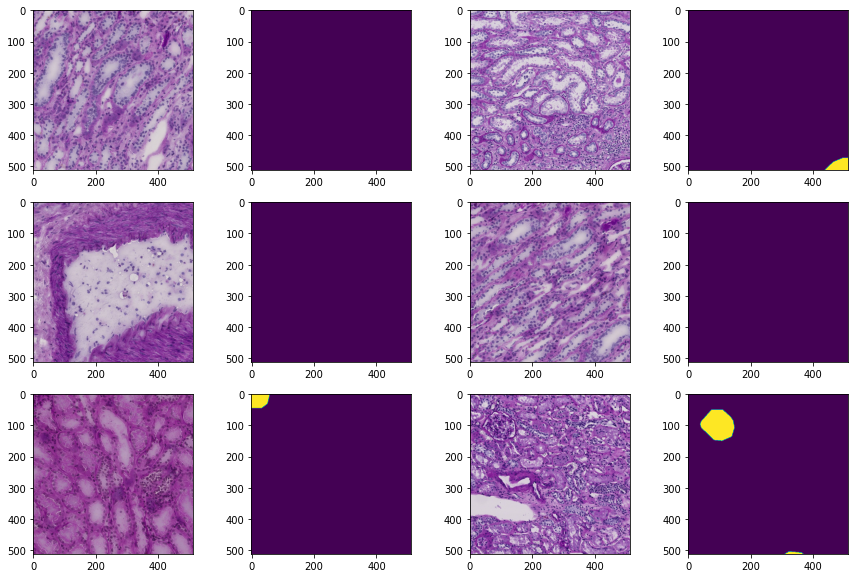

In [5]:
train_df = pd.read_csv('../../../../../hdd/storage/kidney_segmentation/input_kaggle/train.csv')
train_dataset = HuBMAPDataset(train_df, train='val', transform=True)
plt.figure(figsize=(15,10))
for i in range(6):
    image, mask = train_dataset[i]
    plt.subplot(3,4,2*i+1)
    plt.imshow(np.transpose((image), (1,2,0)))
    plt.subplot(3,4,2*i+2)
    plt.imshow(mask)

In [6]:
if CFG.data==1024:
    directory_list = os.listdir(RESIZED_DATA_DIR + '1024*1024/train')
elif CFG.data==512:
    directory_list = os.listdir(RESIZED_DATA_DIR + '512*512/train')
elif CFG.data==256:
    directory_list = os.listdir(RESIZED_DATA_DIR + '256*256/train')
directory_list = [fnames.split('_')[0] for fnames in directory_list]
dir_df = pd.DataFrame(directory_list, columns=['id'])
dir_df

,id
0,afa5e8098
1,0486052bb
2,afa5e8098
3,afa5e8098
4,095bf7a1f
...,...
9579,b2dc8411c
9580,c68fe75ea
9581,095bf7a1f
9582,095bf7a1f


In [7]:
class DiceCoef(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceCoef, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        # comment out if your model contains a sigmoid or equivalent activation layer
        # print("1 inputs = ", inputs)
#         inputs = F.sigmoid(inputs)
        # print("2 inputs = ", inputs)
        # print('targets = ', targets)
        # flatten label and prediction tensors
        inputs = inputs.view(-1)
        inputs_new = inputs > PREDICTION_THRESHOLD
        # print("3 inputs = ", inputs)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice = (2. * intersection + smooth) / (inputs.sum() + targets.sum() + smooth)

        intersection_new = (inputs_new * targets).sum()
        dice_new = (2. * intersection_new + smooth) / (inputs_new.sum() + targets.sum() + smooth)

        return dice, dice_new

In [8]:
def HuBMAPMetric(outputs, targets):
#     model.to(device)
#     images = images.to(device)
#     targets = targets.to(device)
#     outputs = model(images)
    criterion = DiceCoef()
    metric = criterion(outputs, targets)
    return metric

In [9]:
class HuBMAP(nn.Module):
    def __init__(self):
        super(HuBMAP, self).__init__()
        self.cnn_model = smp.Unet('resnet34', classes=1)
        
        #self.cnn_model.decoder.blocks.append(self.cnn_model.decoder.blocks[-1])
        #self.cnn_model.decoder.blocks[-2] = self.cnn_model.decoder.blocks[-3]
    
    def forward(self, imgs):
        img_segs = self.cnn_model(imgs)
        return img_segs

In [10]:
def Make_prediction(img, models, tta = True):
    pred = None
    with torch.no_grad():
        for model in models:
            p_tta = None
            p = model(img)
            p = torch.sigmoid(p).detach()
            if p_tta is None:
                p_tta = p
            else:
                p_tta += p
            if tta:
                #x,y,xy flips as TTA
                flips = [[-1],[-2],[-2,-1]]
                for f in flips:
                    imgf = torch.flip(img, f)
                    p = model(imgf)
                    p = torch.flip(p, f)
                    p_tta += torch.sigmoid(p).detach()
                p_tta /= (1+len(flips))
            if pred is None:
                pred = p_tta
            else:
                pred += p_tta
        pred /= len(models)
#     print('pred = ', pred)
    return pred

In [11]:
def valid(device, validloader, models):
    t = time.time()
    total_loss = 0
    total_metric = 0
    total_metric_new = 0
    for step, (images, targets) in enumerate(validloader):
        images = images.to(device)
        outputs = Make_prediction(images, models)
#         print(outputs)

#         print(outputs.shape)
        outputs = outputs
        metric, metric_new = HuBMAPMetric(outputs.cpu(), targets)
        total_metric += metric
        total_metric_new += metric_new

        if ((step+1)%10==0 or (step+1)==len(validloader)):
            print(
#                     f'loss: {total_loss/len(validloader):.4f}, ' + \
                    f'dice_coef: {total_metric/len(validloader):.4f}, ' + \
                    f'dice_coef_new: {total_metric_new/len(validloader):.4f}, ' + \
                    f'time: {(time.time() - t):.4f}', end= '\r' if (step + 1) != len(validloader) else '\n'
                )
    return total_metric_new/len(validloader)

In [12]:
FOLDS = [0, 1, 2, 3, 4]
scores = []
for fold_number in FOLDS:
    weight_path = f"FOLD-{fold_number}-model_resnet34.pth"
    
    models = []
    state_dict = torch.load(weight_path, map_location=torch.device('cpu'))
    model = HuBMAP().to(device)
    model.load_state_dict(state_dict)
    model.eval()
    model.to(device)
    models.append(model)
    del state_dict
    
    dir_df = pd.read_csv("dir_df.csv")
    dir_df = dir_df[dir_df.Folds == fold_number]
    TEST_IMAGES = list(dir_df.id.unique())
    
    val_ids = pd.DataFrame({'id': TEST_IMAGES})
    val_ds = HuBMAPDataset(val_ids, train='val', transform=True)
    validloader = DataLoader(val_ds, batch_size=CFG.batch_size, pin_memory=True, shuffle=False, num_workers=4)
    
    with torch.no_grad():
        score = valid(device, validloader, models)
    
    scores.append(score.to('cpu').item())
    torch.cuda.empty_cache()

scores = np.array(scores)
cv_dice = scores.mean()
print("cv_dice = ", cv_dice)

dice_coef: 0.3704, dice_coef_new: 0.9057, time: 37.7985
dice_coef: 0.2014, dice_coef_new: 0.9266, time: 37.7379
dice_coef: 0.3244, dice_coef_new: 0.9146, time: 32.9472
dice_coef: 0.4238, dice_coef_new: 0.9243, time: 37.8104
dice_coef: 0.3313, dice_coef_new: 0.9395, time: 33.1272
cv_dice =  0.9221521019935608


In [13]:
0.9300709009170532 - 0.918

0.012070900917053207

In [14]:
(0.93466365 + 0.90379208 + 0.92859036 + 0.94053757 + 0.94214767) / 5

0.929946266